In [19]:
import gymnasium as gym
from gymnasium.utils.play import play
from gymnasium.wrappers import RecordVideo, TransformObservation
from gymnasium import spaces
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from Utils import plot_rewards, plot_epsilon, test_utils
from collections import defaultdict
%matplotlib inline

In [6]:
def get_env(record_video=False, record_every=1, folder="./videos" ):
    """
    Create the MountainCar environment with optional video recording and statistics.
    Args:
        record_video (bool): Whether to record video of the episodes.
        record_every (int): Frequency of recording episodes.
        folder (str): Folder to save the recorded videos.
    Returns:
        env (gym.Env): The MountainCar environment.

    See also:
        https://gymnasium.farama.org/introduction/record_agent/
    """
    # Initialise the environment
    env = gym.make("MountainCar-v0", render_mode="rgb_array")

    if record_video:
        env = RecordVideo(env, video_folder=folder, name_prefix="MountainCar",
                    episode_trigger=lambda x: x % record_every == 0)

    return env

In [8]:
env = get_env(record_video=True, record_every=1, folder="./videos/discret_10/random_actions")

for episode_num in range(5):
    obs, info = env.reset()

    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # Random action
        obs, reward, terminated, truncated, info = env.step(action)
        episode_over = terminated or truncated

c:\Users\joaco\anaconda3\envs\ia-taller\Lib\site-packages\gymnasium\wrappers\rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


### Uso de `TransformObservation` para Discretizar el Ambiente

Gymnasium ofrece un wrapper muy práctico llamado `TransformObservation` que permite transformar las observaciones de manera sencilla sin necesidad de definir una clase personalizada. Esto es especialmente útil cuando se quiere convertir un espacio continuo en un espacio discreto para poder utilizar métodos tabulares como Q-Learning o Sarsa.

Ver [TransformObservation](https://gymnasium.farama.org/api/wrappers/observation_wrappers/#gymnasium.wrappers.TransformObservation) para más detalles.

Discretizamos el ambiente con 10*10 estados

In [9]:
NUMBER_STATES = 10

# Definir la función de transformación para discretizar la observación.
def discretize_obs(obs):
    # observation_space low y high nos permiten conocer los límites de nuestro ambiente para los valores de Posicion y Velocidad.
    env_low = env.observation_space.low
    env_high = env.observation_space.high

    env_den = (env_high - env_low) / NUMBER_STATES
    pos_den = env_den[0]
    vel_den = env_den[1]

    pos_low = env_low[0]
    vel_low = env_low[1]

    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)

    return pos_scaled, vel_scaled

In [10]:
def get_env_discretized(record_video=False, record_every=1, folder="./videos"):
    base_env = get_env(record_video=record_video, record_every=record_every, folder=folder)
    # Discretizar la observación
    new_observation_space = spaces.MultiDiscrete([NUMBER_STATES, NUMBER_STATES])
    return TransformObservation(base_env, discretize_obs, new_observation_space)

In [11]:
env = get_env()
obs, info = env.reset()
print(f"Original observation: {obs}")

env_dis = get_env_discretized()
obs, info = env_dis.reset()
print(f"Discretized observation: {obs}")

Original observation: [-0.47979134  0.        ]
Discretized observation: (3, 5)


## Q-Learning
Q-Learning es un algoritmo de aprendizaje por refuerzo que busca aprender la función de valor óptima $Q^*(s, a)$ para cada par de estado-acción. A través de la exploración y explotación, el agente actualiza su tabla Q utilizando el siguiente algoritmo:

$$
\begin{aligned}
\textbf{Q-Learning (Off-Policy TD Control)} \\[6pt]
\textbf{Parámetros:} & \quad \alpha \in (0,1],\ \varepsilon > 0,\ \gamma \in (0,1].\\[6pt]
\textbf{Inicializar:} & \quad Q(s,a)\ \text{arbitrario para } s \in S,\ a \in A(s), \\
& \quad Q(\text{terminal},\cdot) = 0.\\[6pt]
\textbf{Loop (por cada episodio):} & \\[-2pt]
& \quad \text{Inicializar } S.\\
& \quad \textbf{mientras } S \text{ no sea terminal:}\\
& \quad\quad A \leftarrow \text{acción seleccionada a partir de } S \text{ usando política } \varepsilon\text{-greedy con respecto a } Q.\\
& \quad\quad \text{Ejecutar } A,\ \text{observar } R,\ S'.\\
& \quad\quad Q(S,A) \leftarrow Q(S,A) \;+\; \alpha \Bigl[\,R \;+\; \gamma \max_{a \in A(S')}Q(S',a) \;-\; Q(S,A)\Bigr].\\
& \quad\quad S \leftarrow S'.\\
\end{aligned}
$$


In [12]:
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon_start=1, epsilon_decay=0.9995, epsilon_min=0.05):
    """
    Q-learning algorithm for the MountainCar environment.

    Args:
        env (gym.Env): The environment to train on.
        num_episodes (int): Number of episodes to train.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        epsilon_start (float): Initial exploration rate.
        epsilon_decay (float): Decay rate for exploration.
        epsilon_min (float): Minimum exploration rate.

    Returns:
        Q (np.ndarray): The learned Q-table.
        episode_rewards (list): Rewards per episode.
        epsilons (list): Exploration rates per episode.
    """

    # Initialize Q-table
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Initialize exploration rate
    epsilon = epsilon_start

    # Store rewards and exploration rates
    episode_rewards = []
    epsilons = []

    for episode in tqdm(range(num_episodes)):
        obs, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[obs])  # Exploit

            # Take action and observe new state and reward
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Update Q-value
            best_next_action = np.argmax(Q[new_obs])
            td_target = reward + gamma * Q[new_obs][best_next_action]
            td_delta = td_target - Q[obs][action]
            Q[obs][action] += alpha * td_delta

            obs = new_obs
            total_reward += reward

        episode_rewards.append(total_reward)
        epsilons.append(epsilon)

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)



    return Q, episode_rewards, epsilons


In [13]:
NUMBER_EPISODES = 100_000

env_dis = get_env_discretized(record_video=True, record_every=10_000, folder="./videos/q_learning_training")
Q_ql, rewards_ql, epsilons_ql = q_learning(env_dis, num_episodes=NUMBER_EPISODES)

c:\Users\joaco\anaconda3\envs\ia-taller\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\joaco\Documents\ort\taller_de_ia\laboratorio_4\videos\q_learning_training folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 100000/100000 [09:44<00:00, 171.06it/s]


In [14]:
np.argmax(rewards_ql)

np.int64(32123)

In [15]:
rewards_ql[32123]

-86.0

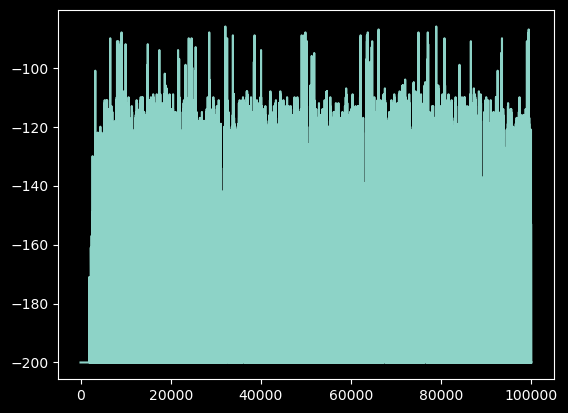

In [17]:
plt.plot(rewards_ql)
plt.show()

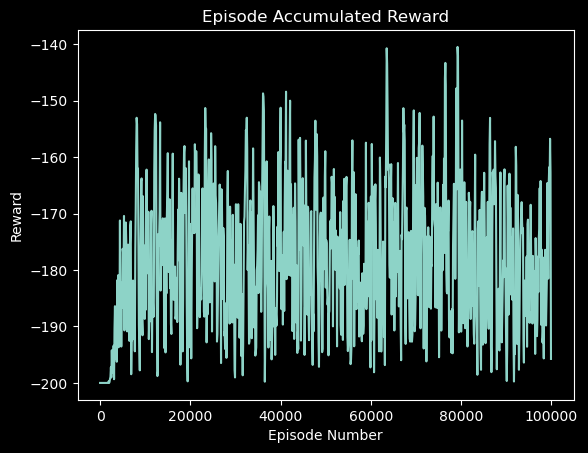

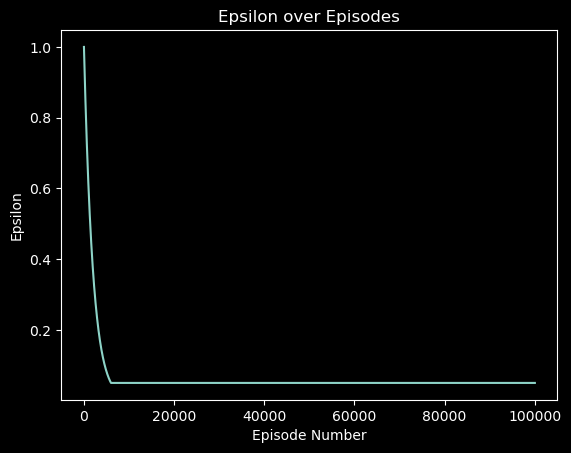

In [20]:
plot_rewards(rewards_ql)
plot_epsilon(epsilons_ql)

In [21]:
def plot_rewards_2(rewards, average_range=1000):
    episode_ticks = int(len(rewards) / average_range)

    avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
    avg_rewards = np.mean(avg_rewards, axis=1)

    plt.plot([i * average_range for i in range(episode_ticks)], avg_rewards)
    # plt.plot(rewards)
    plt.title("Episode Accumulated Reward")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward")
    plt.show()

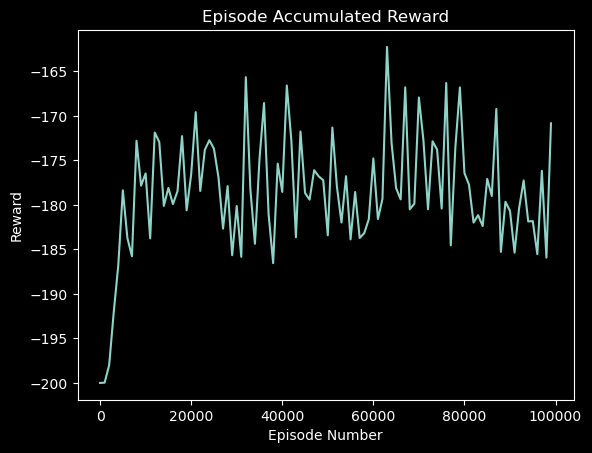

In [22]:
plot_rewards_2(rewards_ql)

In [ ]:
env_dis = get_env_discretized(record_video=True, record_every=1, folder="./videos/q_learning_test")

for episode_num in range(5):
    (pos, vel), info = env_dis.reset()
    episode_over = False
    while not episode_over:
        action = np.argmax(Q_ql[pos, vel])  # Exploit
        (pos, vel), reward, terminated, truncated, info = env_dis.step(action)
        episode_over = terminated or truncated